In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy
from scipy.stats import linregress
import matplotlib
import bluepysnap as bp

In [2]:
%matplotlib widget

In [4]:
s = 'original/1a8bf077-4f6c-4bcb-b257-ca1f3d2388cd/'
s1 = 'remove_inh-l5/d870c2a7-33e1-4002-b8ee-aca5a2fc16b2/'


In [10]:
def getHistByLayer(path_to_sims,bins=None):

    numSims = 10
    numLayers = 6
    numBins = 225
    bins = np.linspace(1975,2200,numBins+1)

    allSpikes = np.zeros([numSims,2,numLayers,numBins])
   
    for sim in range(numSims):

        try:

            s = bp.Simulation( path_to_sims + '/'+str(sim)+'/simulation_config.json' )
    
            c = s.circuit
            layerDF = list(c.nodes.get(group='hex_O1',properties=['layer','synapse_class']))[0][1].loc['S1nonbarrel_neurons']
        
            for layer in np.arange(1,numLayers+1):
    
                layerIds = list(layerDF[layerDF['layer']==layer].index)
    
    
                for classIdx, synClass in enumerate(['EXC','INH']):
    
                    classIds = list(layerDF[layerDF['synapse_class']==synClass].index)
    
                    selectedIds = np.intersect1d(layerIds,classIds)
    
                
                    spikes = s.spikes['S1nonbarrel_neurons'].get(group=selectedIds,t_start=1975,t_stop=2200)
    
                
                    if bins is None:
                        
                        spike_hist,bins = np.histogram(list(spikes.index),bins=numBins)
    
        
                    else:
        
                        spike_hist,_ = np.histogram(list(spikes.index),bins=bins)
                
                    allSpikes[sim,classIdx,layer-1] = spike_hist

        except:
            pass


    return allSpikes, bins

In [11]:
np.linspace(1975,2200,225).shape

(225,)

In [12]:
spikes_original, bins = getHistByLayer(s)

In [13]:
spikes_disconnected, _ = getHistByLayer(s1,bins)

HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 0:
  #000: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 836 in H5Fopen(): unable to synchronously open file
    major: File accessibility
    minor: Unable to open file
  #001: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 796 in H5F__open_api_common(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #002: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3863 in H5VL_file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3675 in H5VL__file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #004: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLnative_file.c line 128 in H5VL__native_file_open(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #005: /opt/hdf5-static/CMak

In [14]:
bins = (bins[:-1]+bins[1:])/2

In [15]:
time = np.arange(1975,2200,.1)

In [16]:
def meanAndCI(EEGs):

    mean = np.mean(EEGs,axis=0)

    lowerbound = scipy.stats.t.ppf(0.05,9,mean,np.std(EEGs,axis=0))
    upperbound = scipy.stats.t.ppf(0.95,9,mean,np.std(EEGs,axis=0))

    return mean, lowerbound, upperbound

In [17]:
def getEEGsByTypes(path):

    EEGs = {}

    for file in os.listdir(path+'/pkls'):
        t = file.split('.')[0].split('g')[1]
        
        EEGs[t] = pd.read_pickle(path+'/pkls/'+file).values[19750:22000,0] 

    return EEGs

In [18]:
def getEEGByLayer(path_to_sims):

    duration = 22000-19750

    allEEGList = []

    for sim in range(10):

        s = bp.Simulation( path_to_sims +'/'+str(sim) + '/simulation_config.json' )
        c = s.circuit
        
    
        eegEXC = np.zeros((7,duration))
        eegINH = np.zeros((7,duration))
    
        eegList = [eegEXC, eegINH]

        EEGsByTypes = getEEGsByTypes(path_to_sims +'/'+str(sim))
    
        for mtype in np.sort(np.unique(list(EEGsByTypes.keys()))):
    
            synsDF = list(c.nodes.get(group=mtype,properties=['synapse_class']))[0][1].loc['S1nonbarrel_neurons'].iloc[0].values
    
            if synsDF=='EXC':
                synIdx = 0
            elif synsDF=='INH':
                synIdx = 1
    
            layer = int(mtype.split('_')[0].split('L')[1])
    
            if layer == 2 or layer == 3 or layer == 23:
                layer = 2
    
            eegList[synIdx][layer] += (EEGsByTypes[mtype]-np.mean(EEGsByTypes[mtype][:250]))

            allEEGList.append(eegList)                          
    
    
    return np.array(allEEGList)

In [52]:
def getEEGs(path):

    EEGs = list(np.zeros(10))

    for i in range(10):

        for file in os.listdir(path+'/'+str(i)+'/pkls'):

            print(pd.read_pickle(path+'/'+str(i)+'/pkls/'+file).values[19750:22000,0].shape)

            EEGs[i] += pd.read_pickle(path+'/'+str(i)+'/pkls/'+file).values[19750:22000,0] 

    
    EEGs = np.array(EEGs)
    EEGs -= np.mean(EEGs[:,:250],axis=-1)[:,np.newaxis]

    return EEGs

In [34]:
for file in os.listdir(s+'/'+str(0)+'/pkls')[:1]:
    p = pd.read_pickle(s+'/'+str(0)+'/pkls/'+file).values[19750:22000,0] 

In [37]:
p[:,:250]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [36]:
s

'original/1a8bf077-4f6c-4bcb-b257-ca1f3d2388cd/'

In [20]:
def getStuff(path):

    EEGs = getEEGs(path)
    mean, lowerbound, upperbound = meanAndCI(EEGs)

    return mean, lowerbound, upperbound

In [21]:
def getByLayer(path):

    EEGs = np.array(getEEGByLayer(path))
    mean, lowerbound, upperbound = meanAndCI(EEGs)

    return mean, lowerbound, upperbound 

In [39]:
meanEEG, lowerboundEEG, upperboundEEG = getStuff(s)

In [54]:
mean_layer, lowerbound_layer, upperbound_layer = getByLayer(s)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [53]:
meanEEG_disconnected, lowerboundEEG_disconnected, upperboundEEG_disconnected = getStuff(s1)

(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)
(2250,)


/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2504238/ipykernel_197078/4287880813.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  EEGs = np.array(EEGs)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [55]:
mean_layer_disconnected, lowerbound_layer_disconnected, upperbound_layer_disconnected = getByLayer(s1)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [56]:
mean_spikes,lowerbound_spikes,upperbound_spikes = meanAndCI(spikes_original)
mean_spikes_disconnected,lowerbound_spikes_disconnected,upperbound_spikes_disconnected = meanAndCI(spikes_disconnected)


In [57]:
time = np.linspace(0,225,2250)

In [58]:
def getTimeIndices(bins,startTime=0,endTime=225):

    time = np.arange(startTime+1975,endTime+1975,.1)

    timeIndices = []
    for t in bins:
        index = np.argmin(np.abs(t-time))
        timeIndices.append(index)

    return timeIndices

In [59]:
def getCorrelationsByLayer(EEGs, spikes,bins=np.arange(225),startTime=0,endTime=225):

    timeIndices = getTimeIndices(bins,startTime,endTime)

    correlationMatrix = np.zeros([5,5])
    
    for i in range(5):
    
        for j in range(5):
        
            correlationMatrix[i,j] = scipy.stats.pearsonr(spikes[i],EEGs[j][timeIndices]).statistic

    return correlationMatrix

In [60]:
eegDifference = np.sum(mean_layer,axis=0)-np.sum(mean_layer_disconnected,axis=0)

In [ ]:
time = np.arange(0+1975,225+1975,.1)

In [29]:
bins

array([1975.5, 1976.5, 1977.5, 1978.5, 1979.5, 1980.5, 1981.5, 1982.5,
       1983.5, 1984.5, 1985.5, 1986.5, 1987.5, 1988.5, 1989.5, 1990.5,
       1991.5, 1992.5, 1993.5, 1994.5, 1995.5, 1996.5, 1997.5, 1998.5,
       1999.5, 2000.5, 2001.5, 2002.5, 2003.5, 2004.5, 2005.5, 2006.5,
       2007.5, 2008.5, 2009.5, 2010.5, 2011.5, 2012.5, 2013.5, 2014.5,
       2015.5, 2016.5, 2017.5, 2018.5, 2019.5, 2020.5, 2021.5, 2022.5,
       2023.5, 2024.5, 2025.5, 2026.5, 2027.5, 2028.5, 2029.5, 2030.5,
       2031.5, 2032.5, 2033.5, 2034.5, 2035.5, 2036.5, 2037.5, 2038.5,
       2039.5, 2040.5, 2041.5, 2042.5, 2043.5, 2044.5, 2045.5, 2046.5,
       2047.5, 2048.5, 2049.5, 2050.5, 2051.5, 2052.5, 2053.5, 2054.5,
       2055.5, 2056.5, 2057.5, 2058.5, 2059.5, 2060.5, 2061.5, 2062.5,
       2063.5, 2064.5, 2065.5, 2066.5, 2067.5, 2068.5, 2069.5, 2070.5,
       2071.5, 2072.5, 2073.5, 2074.5, 2075.5, 2076.5, 2077.5, 2078.5,
       2079.5, 2080.5, 2081.5, 2082.5, 2083.5, 2084.5, 2085.5, 2086.5,
      

In [62]:
allSpikes = mean_spikes.sum(axis=0)
lowerbound_spikes = lowerbound_spikes.sum(axis=0)
upperbound_spikes=upperbound_spikes.sum(axis=0)

# allSpikes = mean_spikes[1]
# lowerbound_spikes = lowerbound_spikes[1]
# upperbound_spikes=upperbound_spikes[1]

In [63]:
lowerbound_spikes_disconnected.shape

(2, 6, 225)

In [64]:
allSpikes_disconnected = mean_spikes_disconnected.sum(axis=0)
lowerbound_spikes_disconnected = lowerbound_spikes_disconnected.sum(axis=0)
upperbound_spikes_disconnected=upperbound_spikes_disconnected.sum(axis=0)

# allSpikes_disconnected = mean_spikes_disconnected[1]
# lowerbound_spikes_disconnected = lowerbound_spikes_disconnected[1]
# upperbound_spikes_disconnected=upperbound_spikes_disconnected[1]

In [32]:
mean_layer.shape

(2, 7, 2250)

In [ ]:
correlationsExcExc = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[0])
correlationsExcExcP = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=35,endTime=45)
correlationsExcExcN = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=45,endTime=60)

correlationsExcExcDiff = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[0])
correlationsExcExcDiffP = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=35,endTime=45)
correlationsExcExcDiffN = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=45,endTime=60)
correlationsExcExcDiffL = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[0],bins=np.arange(225),startTime=60,endTime=200)


In [ ]:
correlationsInhExc = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[1])
correlationsInhExcP = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=35,endTime=45)
correlationsInhExcN = getCorrelationsByLayer(mean_layer[0,[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=45,endTime=60)

correlationsInhExcDiff = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[1])
correlationsInhExcDiffP = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=35,endTime=45)
correlationsInhExcDiffN = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=45,endTime=60)
correlationsInhExcDiffL = getCorrelationsByLayer(eegDifference[[1,2,4,5,6]],mean_spikes[1],bins=np.arange(225),startTime=60,endTime=200)


In [68]:
plotTime = np.linspace(-25,200,2250)

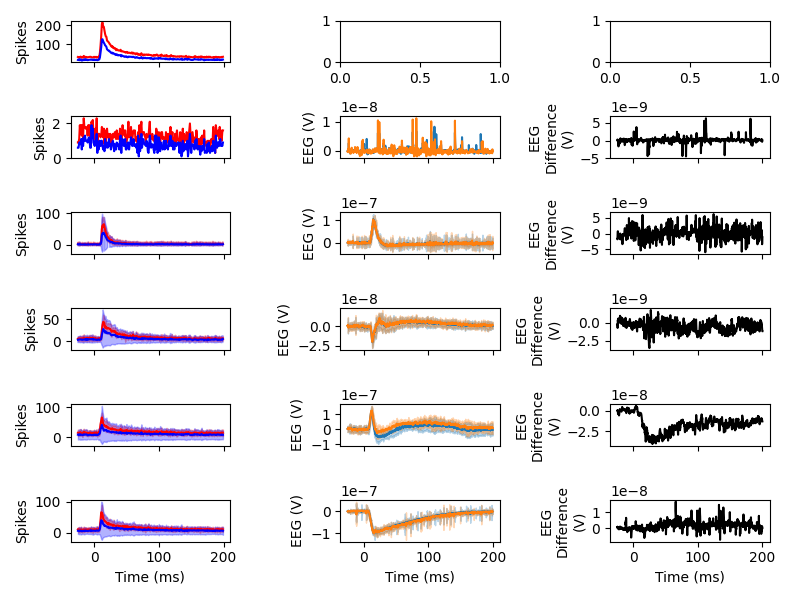

In [69]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,6))

gs = GridSpec(6,3, figure=fig)

ax = fig.add_subplot(gs[0,0])

ax.plot(np.arange(-25,200),np.sum(allSpikes,axis=0),c='r')
ax.plot(np.arange(-25,200),np.sum(allSpikes_disconnected,axis=0),c='b')
ax.fill_between(np.arange(-25,200),np.sum(lowerbound_spikes,axis=0),np.sum(upperbound_spikes,axis=0),color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),np.sum(lowerbound_spikes_disconnected,axis=0),np.sum(upperbound_spikes_disconnected,axis=0),color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])

ax = fig.add_subplot(gs[0,1])
                     
# ax.plot(time,meanEEG)
# ax.plot(time,meanEEG_disconnected)
# ax.fill_between(time,lowerboundEEG,upperboundEEG,color='C0',alpha=0.3)
# ax.fill_between(time,lowerboundEEG_disconnected,upperboundEEG_disconnected,color='C1',alpha=0.3)
# ax.set_ylabel('EEG (V)')
# ax.set_xticklabels([])

ax = fig.add_subplot(gs[0,2])
                     
# ax.plot(time,meanEEG-meanEEG_disconnected,c='k')
# ax.set_ylabel('EEG\nDifference\n(V)')
# ax.set_xticklabels([])

    
ax = fig.add_subplot(gs[1,0])

ax.plot(np.arange(-25,200),allSpikes[0],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[0],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[0],upperbound_spikes[0],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[0],upperbound_spikes_disconnected[0],color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])


ax = fig.add_subplot(gs[2,0])

ax.plot(np.arange(-25,200),allSpikes[1]+allSpikes[2],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[1]+allSpikes_disconnected[2],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[1]+lowerbound_spikes[2],upperbound_spikes[1]+upperbound_spikes[2],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[1]+lowerbound_spikes_disconnected[2],upperbound_spikes_disconnected[1]+upperbound_spikes_disconnected[2],color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])


ax = fig.add_subplot(gs[3,0])

ax.plot(np.arange(-25,200),allSpikes[3],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[3],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[3],upperbound_spikes[3],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[3],upperbound_spikes_disconnected[3],color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])


ax = fig.add_subplot(gs[4,0])

ax.plot(np.arange(-25,200),allSpikes[4],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[4],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[4],upperbound_spikes[4],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[4],upperbound_spikes_disconnected[4],color='b',alpha=0.3)
ax.set_ylabel('Spikes')
ax.set_xticklabels([])

ax = fig.add_subplot(gs[5,0])

ax.plot(np.arange(-25,200),allSpikes[5],c='r')  
ax.plot(np.arange(-25,200),allSpikes_disconnected[5],c='b')  

ax.fill_between(np.arange(-25,200),lowerbound_spikes[5],upperbound_spikes[5],color='r',alpha=0.3)
ax.fill_between(np.arange(-25,200),lowerbound_spikes_disconnected[5],upperbound_spikes_disconnected[5],color='b',alpha=0.3)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Spikes')

ax0 = fig.add_subplot(gs[1,1])
ax1 = fig.add_subplot(gs[2,1])
ax2 = fig.add_subplot(gs[3,1])
ax3 = fig.add_subplot(gs[4,1])
ax4 = fig.add_subplot(gs[5,1])

axes = [ax0,ax1,ax2,ax3,ax4]


for i, layer in enumerate([1,2,4,5,6]):

    
    ax = axes[i]
    ax.plot(plotTime,np.sum(mean_layer[:,layer],axis=0))  
    ax.plot(plotTime,np.sum(mean_layer_disconnected[:,layer],axis=0))  
    ax.fill_between(plotTime,np.sum(lowerbound_layer[:,layer],axis=0),np.sum(upperbound_layer[:,layer],axis=0),color='C0',alpha=0.3)
    ax.fill_between(plotTime,np.sum(lowerbound_layer_disconnected[:,layer],axis=0),np.sum(upperbound_layer_disconnected[:,layer],axis=0),color='C1',alpha=0.3)

    if layer == 6:
        ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('EEG (V)')

ax0 = fig.add_subplot(gs[1,2])
ax1 = fig.add_subplot(gs[2,2])
ax2 = fig.add_subplot(gs[3,2])
ax3 = fig.add_subplot(gs[4,2])
ax4 = fig.add_subplot(gs[5,2])

axes = [ax0,ax1,ax2,ax3,ax4]


for i, layer in enumerate([1,2,4,5,6]):

    
    ax = axes[i]
    ax.plot(plotTime,np.sum(mean_layer[:,layer],axis=0)-np.sum(mean_layer_disconnected[:,layer],axis=0),c='k') 
    if layer == 6:
        ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('EEG\nDifference\n(V)')


plt.tight_layout()
# plt.show()
plt.savefig('figures/whiskerflick_eeg.png',dpi=300)

NameError: name 'GridSpec' is not defined

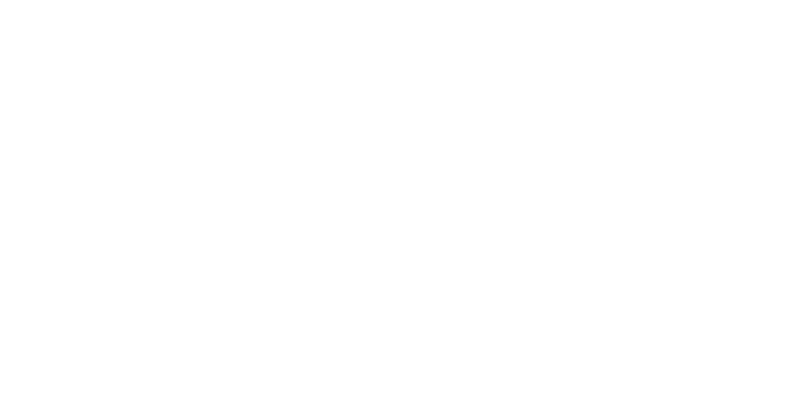

In [25]:
fig = plt.figure(figsize=(8,4))

gs = GridSpec(2,4, figure=fig)

ax = fig.add_subplot(gs[0,0])
ax.imshow(correlationsExcExcDiff,cmap='bwr',vmin=-1,vmax=1)
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xticks([])

ax = fig.add_subplot(gs[0,1])
ax.imshow(correlationsExcExc)
ax.imshow(correlationsExcExcDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.yticks([])
plt.xticks([])

ax = fig.add_subplot(gs[0,2])
ax.imshow(correlationsExcExc)
ax.imshow(correlationsExcExcDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks([])
plt.yticks([])


ax = fig.add_subplot(gs[0,3])
ax.imshow(correlationsExcExcDiffL,cmap='bwr',vmin=-1,vmax=1)
plt.yticks([])
plt.xticks([])


plt.yticks([])
plt.xticks([])

plt.yticks([])
plt.xticks([])

ax = fig.add_subplot(gs[1,0])
ax.imshow(correlationsInhExcDiff,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])

ax = fig.add_subplot(gs[1,1])
ax.imshow(correlationsInhExcDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])

ax = fig.add_subplot(gs[1,2])
ax.imshow(correlationsInhExcDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])

ax = fig.add_subplot(gs[1,3])
ax.imshow(correlationsInhExcDiffL,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])

plt.tight_layout()
# plt.savefig('figures/whiskerflick_correlations.png',dpi=300)

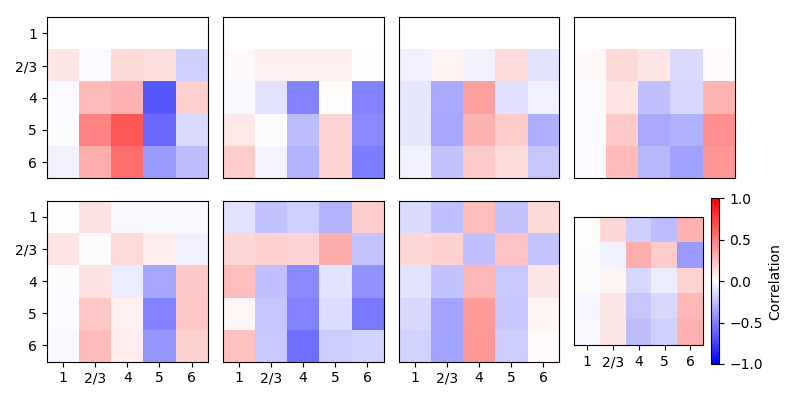

In [175]:
fig = plt.figure(figsize=(8,4))

gs = GridSpec(2,4, figure=fig)

ax = fig.add_subplot(gs[0,0])
ax.imshow(correlationsExcExcDiff,cmap='bwr',vmin=-1,vmax=1)
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xticks([])

ax = fig.add_subplot(gs[0,1])
ax.imshow(correlationsExcExc)
ax.imshow(correlationsExcExcDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.yticks([])
plt.xticks([])

ax = fig.add_subplot(gs[0,2])
ax.imshow(correlationsExcExc)
ax.imshow(correlationsExcExcDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks([])
plt.yticks([])


ax = fig.add_subplot(gs[0,3])
ax.imshow(correlationsExcExcDiffL,cmap='bwr',vmin=-1,vmax=1)
plt.yticks([])
plt.xticks([])


plt.yticks([])
plt.xticks([])

plt.yticks([])
plt.xticks([])

ax = fig.add_subplot(gs[1,0])
ax.imshow(correlationsInhExcDiff,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])

ax = fig.add_subplot(gs[1,1])
ax.imshow(correlationsInhExcDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])

ax = fig.add_subplot(gs[1,2])
ax.imshow(correlationsInhExcDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])

ax = fig.add_subplot(gs[1,3])
p = ax.imshow(correlationsInhExcDiffL,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks([])
plt.colorbar(p, label='Correlation')

plt.tight_layout()
plt.savefig('figures/whiskerflick_colorbar.png',dpi=300)